In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad

from locnetwork import Network
from locinverse_network import NetworkInverse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(16)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 16


(1000,)
(1000,)
(10,)
(10,)


Text(0.5, 0, 'Time (s)')

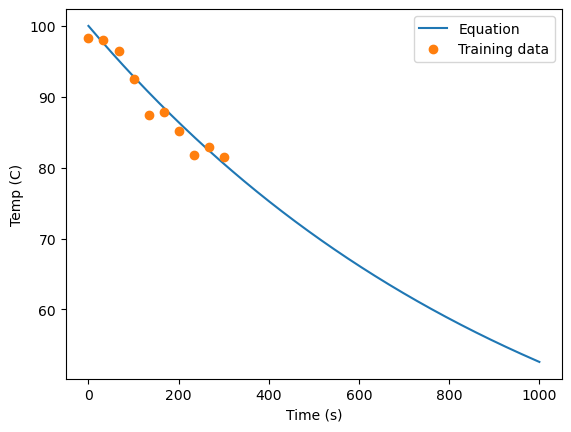

In [5]:
Tenv = 25 #temp of environment
T0 = 100 #initial temperature
k = 0.001 #arbitrary start point for cooling const. - note, we still define it here as we are 
          #'setting up' the training data, and physically the cooling constant does have a value
          #so basically, we want our prediction to show the same value a this in the end
time = np.linspace(0,1000,1000)
np.random.seed()

def true_sol(t):
    return Tenv + (T0 - Tenv)*np.exp(-k*t)

temp = true_sol(time)

t = np.linspace(0,300,10) # for taining data, only up to 300 with step 10
T = true_sol(t) + 2*np.random.randn(10)


print(np.shape(time))
print(np.shape(temp))
print(np.shape(t))
print(np.shape(T))


plt.plot(time, temp)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temp (C)')
plt.xlabel('Time (s)')

In [6]:


def physics_loss_discovery(model: torch.nn.Module):

    ts = torch.linspace(0,1000,steps=1000).view(-1,1).requires_grad_(True).to(torch.float32)
    Ts = model(ts)

    dT = grad(Ts, ts, grad_outputs=torch.ones_like(Ts), create_graph=True)[0]
    pde = model.r * (Tenv - Ts) - dT

    return torch.mean(pde**2)

Epoch: 0/30000, loss: 7611.46
Epoch: 3000/30000, loss: 2931.45
Epoch: 6000/30000, loss: 745.75
Epoch: 9000/30000, loss: 33.89
Epoch: 12000/30000, loss: 11.58
Epoch: 15000/30000, loss: 7.40
Epoch: 18000/30000, loss: 6.24
Epoch: 21000/30000, loss: 5.29
Epoch: 24000/30000, loss: 4.48
Epoch: 27000/30000, loss: 14.75


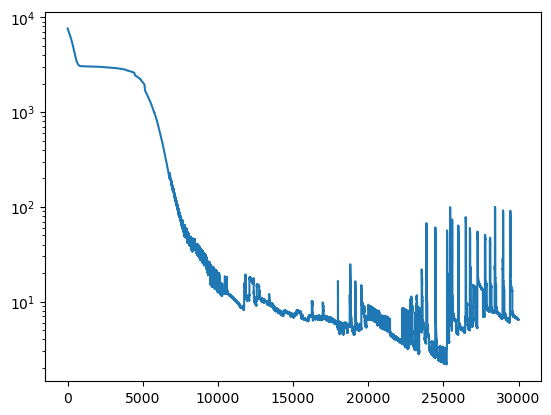

In [7]:
networkinverse = NetworkInverse(1,1,loss2=physics_loss_discovery,loss2_weight=5000,epochs=30000,lr=1e-5)


losses = networkinverse.fit(t,T)
plt.plot(losses)
plt.yscale('log')

Parameter containing:
tensor([0.0009], requires_grad=True)


Text(0.5, 0, 'Time (s)')

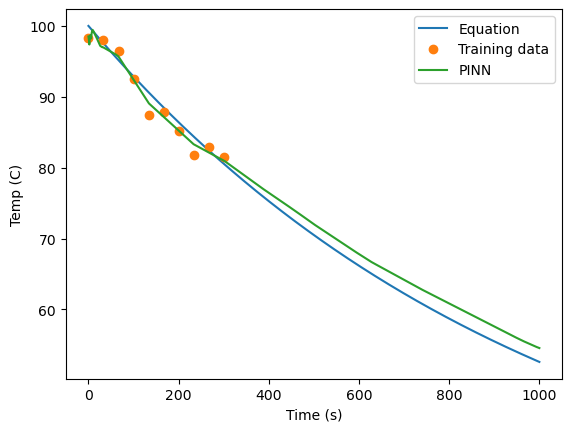

In [8]:
predictions = networkinverse.predict(time)

print(networkinverse.r)

plt.plot(time, temp)
plt.plot(t, T, 'o')
plt.plot(time, predictions)
plt.legend(labels=['Equation', 'Training data', 'PINN'])
plt.ylabel('Temp (C)')
plt.xlabel('Time (s)')
